# Previsão de Votação de Deputados

## A tarefa

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
3. Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
4. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
5. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
    1. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
    2. Experimente outras estratégias de ensembles (e.g. Stacking).
    3. Experimente balancear as classes,  caso estejam desbalanceadas.
Os dados estão neste [link](https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data)

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.

## Sobre os dados

Vamos explorar dados de treino sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.
O modelo escolhido e já treinado será, então, avaliado utilizando os dados da eleição de 2014, de natureza semelhante aos dados de treino.

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import imblearn

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [91]:
# Para regressão linear sem regularização
from sklearn.linear_model import LinearRegression
# Para regressão linear com regularização
from sklearn import metrics
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
# não paramétrica K-NN
from sklearn.neighbors import KNeighborsRegressor
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.datasets import make_regression

In [92]:
# Carregando
eleicoes_train = pd.read_csv('../data/train.csv')
eleicoes_final_test = pd.read_csv('../data/test.csv')
directions = pd.read_csv('../data/directions.csv')
regions = pd.read_csv('../data/regions.csv')

## Pré-processamento

Aqui analisaremos os dados de forma mais ampla, fazendo modificações e preenchendo lacunas quando necessário.

In [93]:
#criando as variável Região e Ideologia (esquerda e direita)
direction2=[]
region2=[]
for index,row in eleicoes_train.iterrows():
    direction2.append(directions[row['partido']][0])  
    region2.append(regions[row['uf']][0])    
eleicoes_train['ideologia'] = direction2  
eleicoes_train['regiao'] = region2
direction2=[]
region2=[]
for index,row in eleicoes_final_test.iterrows():
    direction2.append(directions[row['partido']][0])
    region2.append(regions[row['uf']][0])    
eleicoes_final_test['ideologia'] = direction2
eleicoes_final_test['regiao'] = region2


In [94]:
#eliminando colunas pouco úteis
eleicoes_train = eleicoes_train.loc[:,[
       'uf', 'ano', 'situacao', 'sequencial_candidato', 'nome', 'partido', 'quantidade_doacoes', 'total_receita', 'quantidade_doadores', 
       'recursos_de_outros_candidatos.comites', 'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'cargo', 'sexo', 'grau_instrucao',
       'estado_civil', 'ocupacao', 'ideologia', 'regiao'
    ]]
eleicoes_final_test = eleicoes_final_test.loc[:,[
       'uf', 'ano', 'situacao', 'sequencial_candidato', 'nome', 'partido', 'quantidade_doacoes', 'total_receita', 'quantidade_doadores', 
       'recursos_de_outros_candidatos.comites', 'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'cargo', 'sexo', 'grau_instrucao',
       'estado_civil', 'ocupacao', 'ideologia', 'regiao'
    ]]

In [95]:
#selecionando atributos numéricos
numeric_feats = eleicoes_train.dtypes[eleicoes_train.dtypes != "object"].index

#normalizando variáveis numéricas exceto ano e sequência para escala logaritmica
eleicoes_train[numeric_feats[2:]] = np.log1p(eleicoes_train[numeric_feats[2:]])
eleicoes_final_test[numeric_feats[2:]] = np.log1p(eleicoes_final_test[numeric_feats[2:]])

In [96]:
#obtendo os dummies das variáveis categóricas
eleicoes_train = pd.get_dummies(eleicoes_train, 
                          prefix=['sexo', 'estado_civil', 'regiao', 'ideologia', 'ocupacao','situacao'], 
                          columns=['sexo', 'estado_civil', 'regiao', 'ideologia', 'ocupacao','situacao'])
eleicoes_final_test = pd.get_dummies(eleicoes_final_test, 
                          prefix=['sexo', 'estado_civil', 'regiao', 'ideologia', 'ocupacao','situacao'], 
                          columns=['sexo', 'estado_civil', 'regiao', 'ideologia', 'ocupacao','situacao'])

## Distribuição

Perceba aqui a necessidade de balancear os dados 

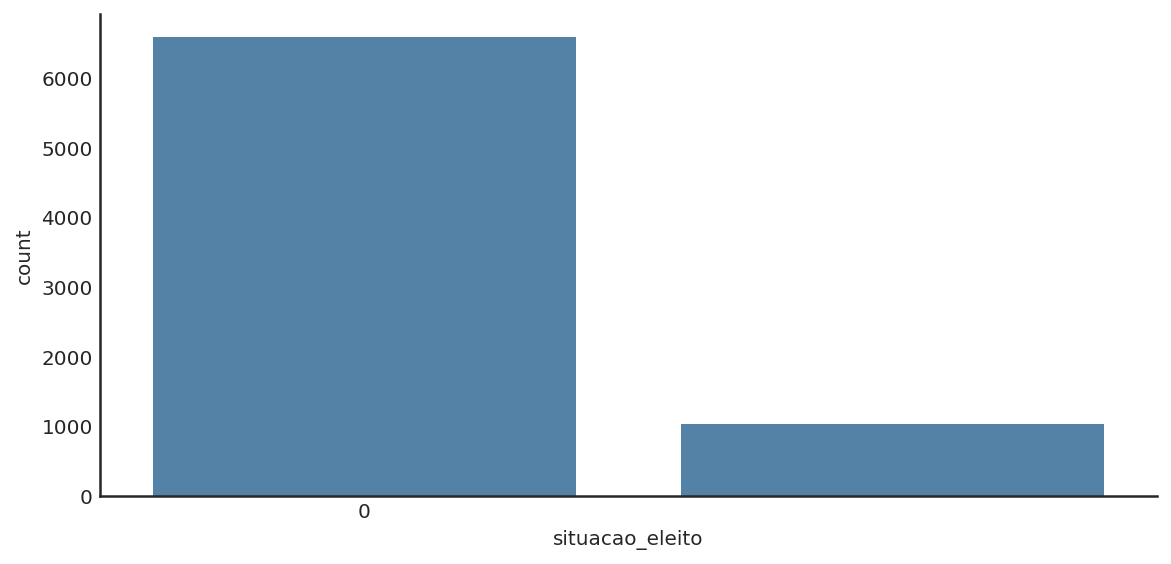

In [97]:

with sns.axes_style('white'):
    g = sns.factorplot("situacao_eleito", data=eleicoes_train, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

In [98]:

#rotina gráfica útil
def plot_2d_space_2(X, y, label='Classes'):   
    colors = ['amarelo', 'roxo']
    alphas = [0.4, 0.0]
    c = y
    l = np.unique(c)
    for situacao,a,l,p in zip(['eleito', 'não eleito'],alphas,np.unique(c),colors):
        plt.scatter(
            X[:,0],
            X[:,1],
            c=c, alpha =a, cmap='viridis', label="{1}='{0}'".format(l,p)
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


Random under-sampling:
1    1026
0    1026
Name: situacao_eleito, dtype: int64


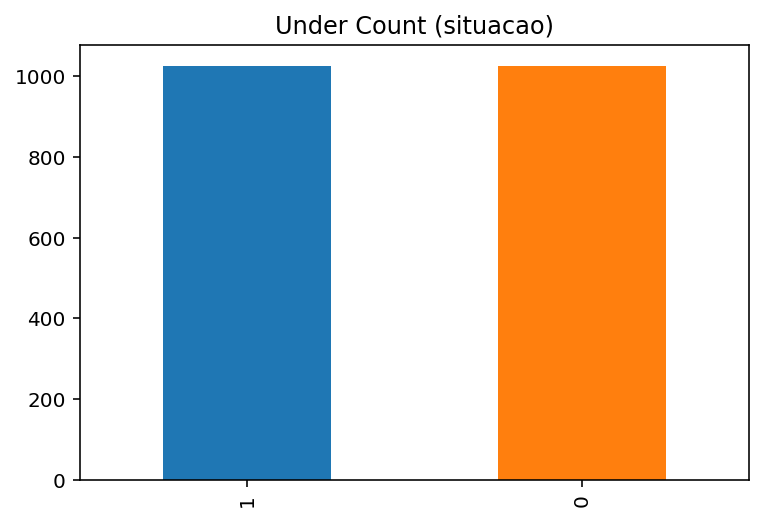

In [99]:
#under sampling simples, sem uso de biblioteca

count_class_0, count_class_1 = eleicoes_train.situacao_eleito.value_counts()

# Divide by class
df_class_0 = eleicoes_train[eleicoes_train['situacao_eleito'] == 0]
df_class_1 = eleicoes_train[eleicoes_train['situacao_eleito'] == 1]



df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.situacao_eleito.value_counts())

df_test_under.situacao_eleito.value_counts().plot(kind='bar', title='Under Count (situacao)');

Random over-sampling:
1    6596
0    6596
Name: situacao_eleito, dtype: int64


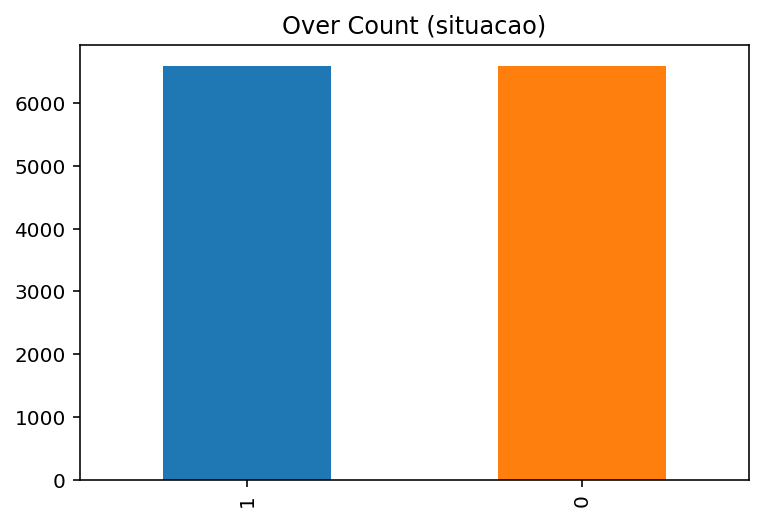

In [100]:
#over sampling simples, sem uso de biblioteca

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.situacao_eleito.value_counts())

df_test_over.situacao_eleito.value_counts().plot(kind='bar', title='Over Count (situacao)');

### Tomek Links

Abaixo é apresentada a estratégia de balanceamento Tomek Links, utilizada em uma das submissões (questão 5). Perceba que este algorítimo não visa equilibrar os dois conjuntos de dados, mas apenas eliminar pontos na fronteira das duas classes, enfatizando a diferença.

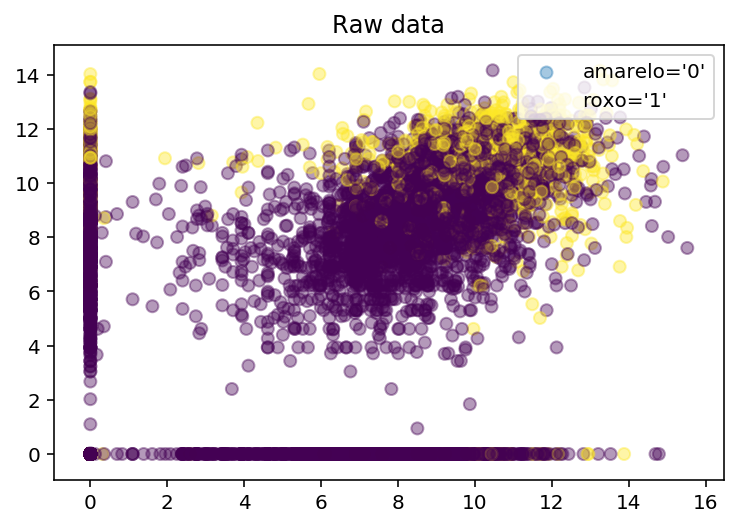

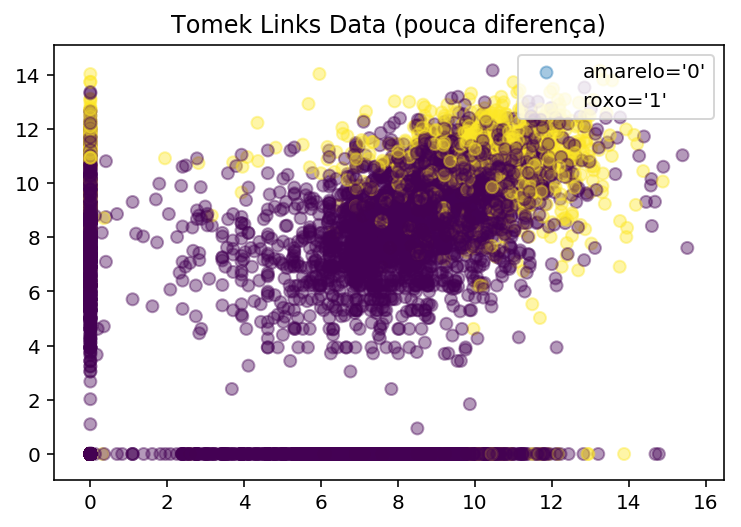

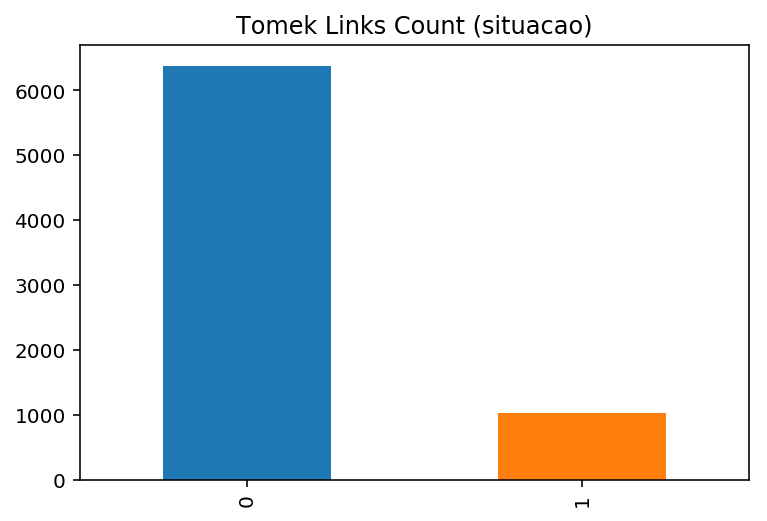

In [101]:
#Under-sampling: Tomek links

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(
    eleicoes_train.loc[:,['recursos_proprios','recursos_de_pessoas_fisicas','ocupacao_DEPUTADO','recursos_de_partido_politico','recursos_de_pessoas_juridicas',"quantidade_doadores",'regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], 
    eleicoes_train.situacao_eleito)

eleicoes_train_balanced = eleicoes_train

indexes=np.asarray(list(set(eleicoes_train_balanced.index.values) - set(eleicoes_train_balanced.index[id_tl].values)))

eleicoes_train_balanced=eleicoes_train_balanced.drop(indexes)

plot_2d_space_2(eleicoes_train.loc[:,['recursos_proprios','recursos_de_pessoas_fisicas','ocupacao_DEPUTADO','recursos_de_partido_politico','recursos_de_pessoas_juridicas',"quantidade_doadores",'regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']].values, eleicoes_train.situacao_eleito, 'Raw data')


plot_2d_space_2(eleicoes_train_balanced.loc[:,['recursos_proprios','recursos_de_pessoas_fisicas','ocupacao_DEPUTADO','recursos_de_partido_politico','recursos_de_pessoas_juridicas',"quantidade_doadores",'regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']].values, eleicoes_train_balanced.situacao_eleito, 'Tomek Links Data (pouca diferença)')


df = pd.DataFrame(X_tl)
df['situacao'] = y_tl
df.situacao.value_counts().plot(kind='bar', title='Tomek Links Count (situacao)');



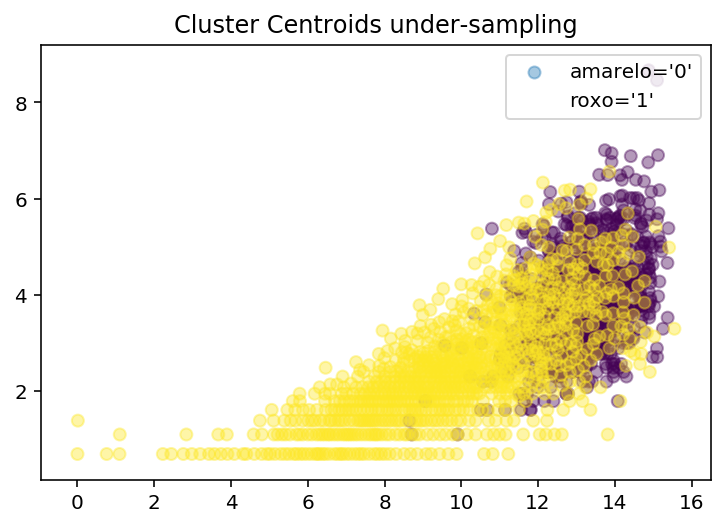

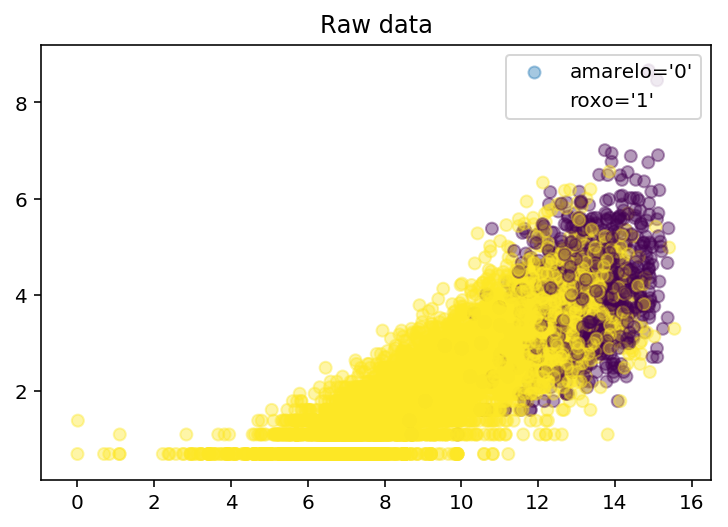

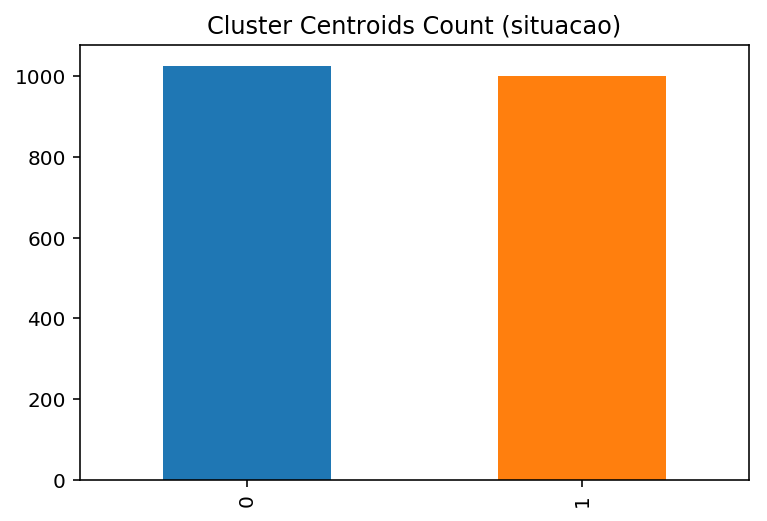

In [102]:
#Under-sampling: Cluster Centroids
from imblearn.under_sampling import ClusterCentroids

#cc = ClusterCentroids()
cc = ClusterCentroids(ratio={1:1000})
X_cc, y_cc = cc.fit_sample(eleicoes_train.loc[:,["total_receita","quantidade_doadores"]], eleicoes_train.situacao_nao_eleito)

plot_2d_space_2(X_cc, y_cc, 'Cluster Centroids under-sampling')

plot_2d_space_2(eleicoes_train.loc[:,['total_receita','quantidade_doadores']].values, eleicoes_train.situacao_nao_eleito, 'Raw data')

df = pd.DataFrame(X_cc)
df['situacao'] = y_cc
df.situacao.value_counts().plot(kind='bar', title='Cluster Centroids Count (situacao)');

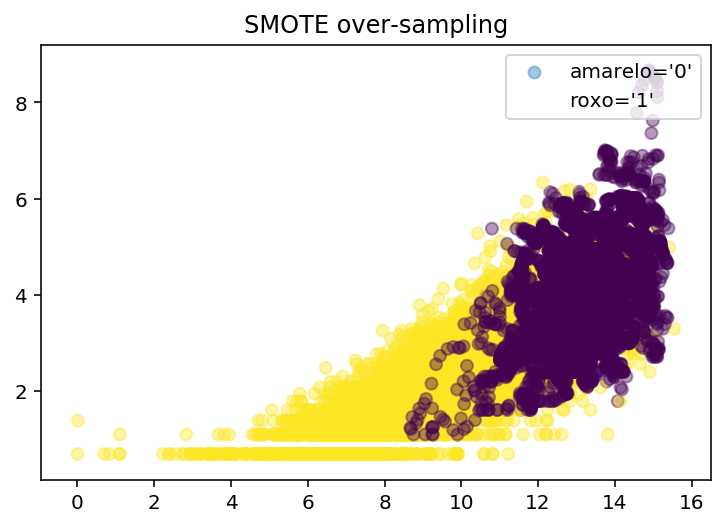

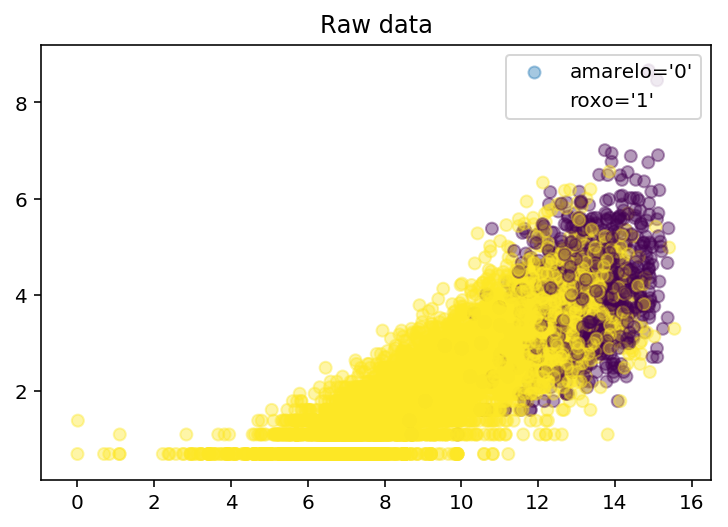

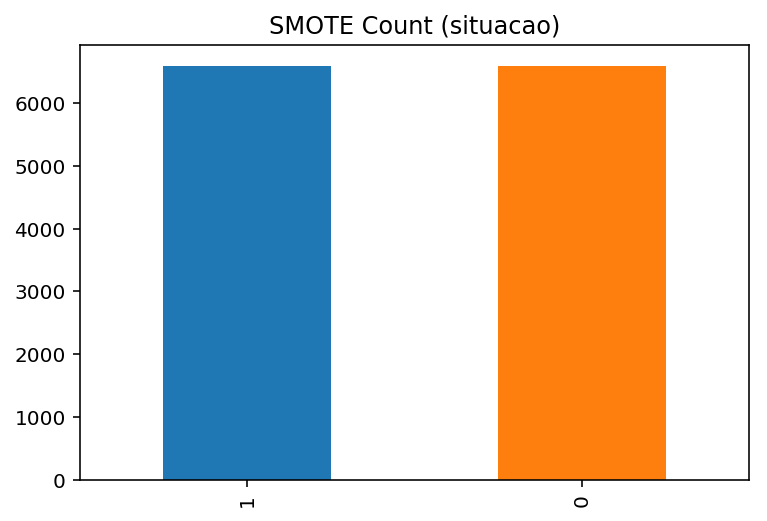

In [103]:

#Over-sampling: SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(eleicoes_train.loc[:,["total_receita","quantidade_doadores"]], eleicoes_train.situacao_nao_eleito)

plot_2d_space_2(X_sm, y_sm, 'SMOTE over-sampling')

plot_2d_space_2(eleicoes_train.loc[:,['total_receita','quantidade_doadores']].values, eleicoes_train.situacao_nao_eleito, 'Raw data')

df = pd.DataFrame(X_sm)
df['situacao'] = y_sm
df.situacao.value_counts().plot(kind='bar', title='SMOTE Count (situacao)');

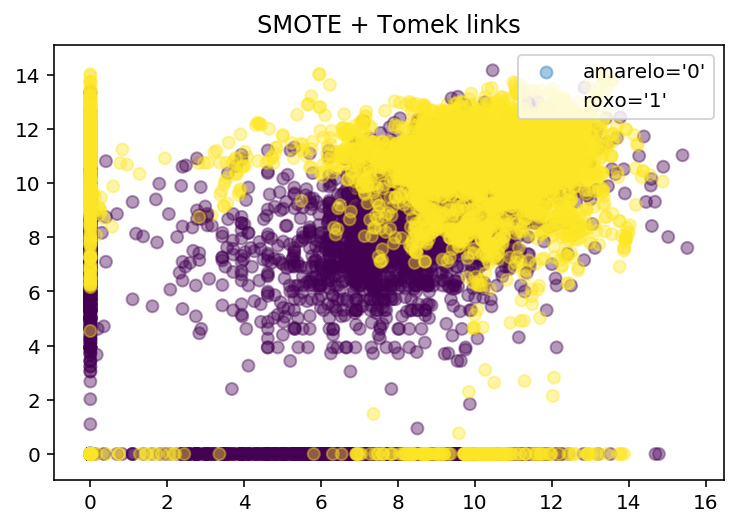

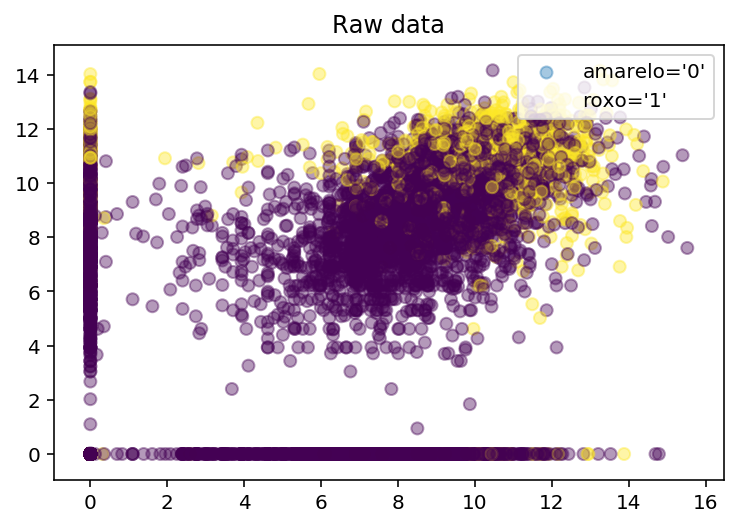

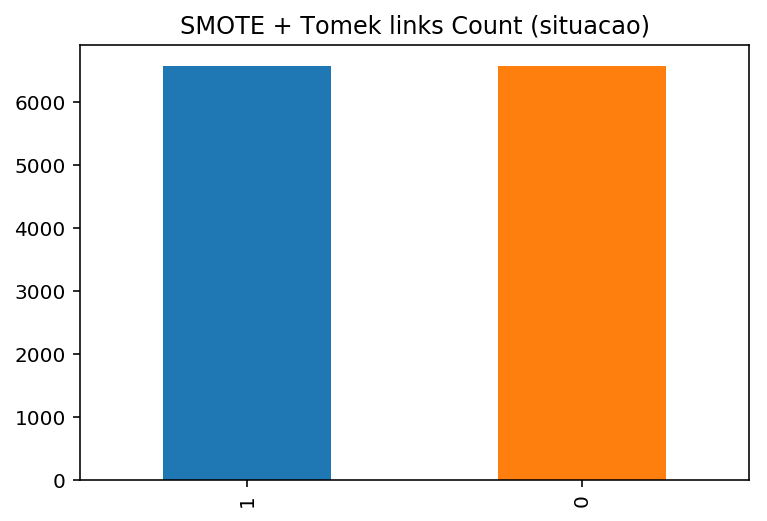

In [113]:
#Over-sampling: SMOTE x Tomek
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(
    eleicoes_train.loc[:,['recursos_proprios','recursos_de_pessoas_fisicas','ocupacao_DEPUTADO','recursos_de_partido_politico','recursos_de_pessoas_juridicas',"quantidade_doadores",'regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], 
    eleicoes_train.situacao_eleito)

#eleicoes_train_balanced = pd.concat([(]X_smt,y_smt],sort='false',axis=1)

plot_2d_space_2(X_smt, y_smt, 'SMOTE + Tomek links')
                                     
plot_2d_space_2(eleicoes_train.loc[:,['recursos_proprios','recursos_de_pessoas_fisicas','ocupacao_DEPUTADO','recursos_de_partido_politico','recursos_de_pessoas_juridicas',"quantidade_doadores",'regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']].values, eleicoes_train.situacao_eleito, 'Raw data')

df = pd.DataFrame(X_smt)
df['situacao'] = y_smt
df.situacao.value_counts().plot(kind='bar', title='SMOTE + Tomek links Count (situacao)');




Agora faremos uma análise copmparativa de variáveis sensíveis a nosso objetivo em função dos dois grupos (eleitos e não-eleitos).

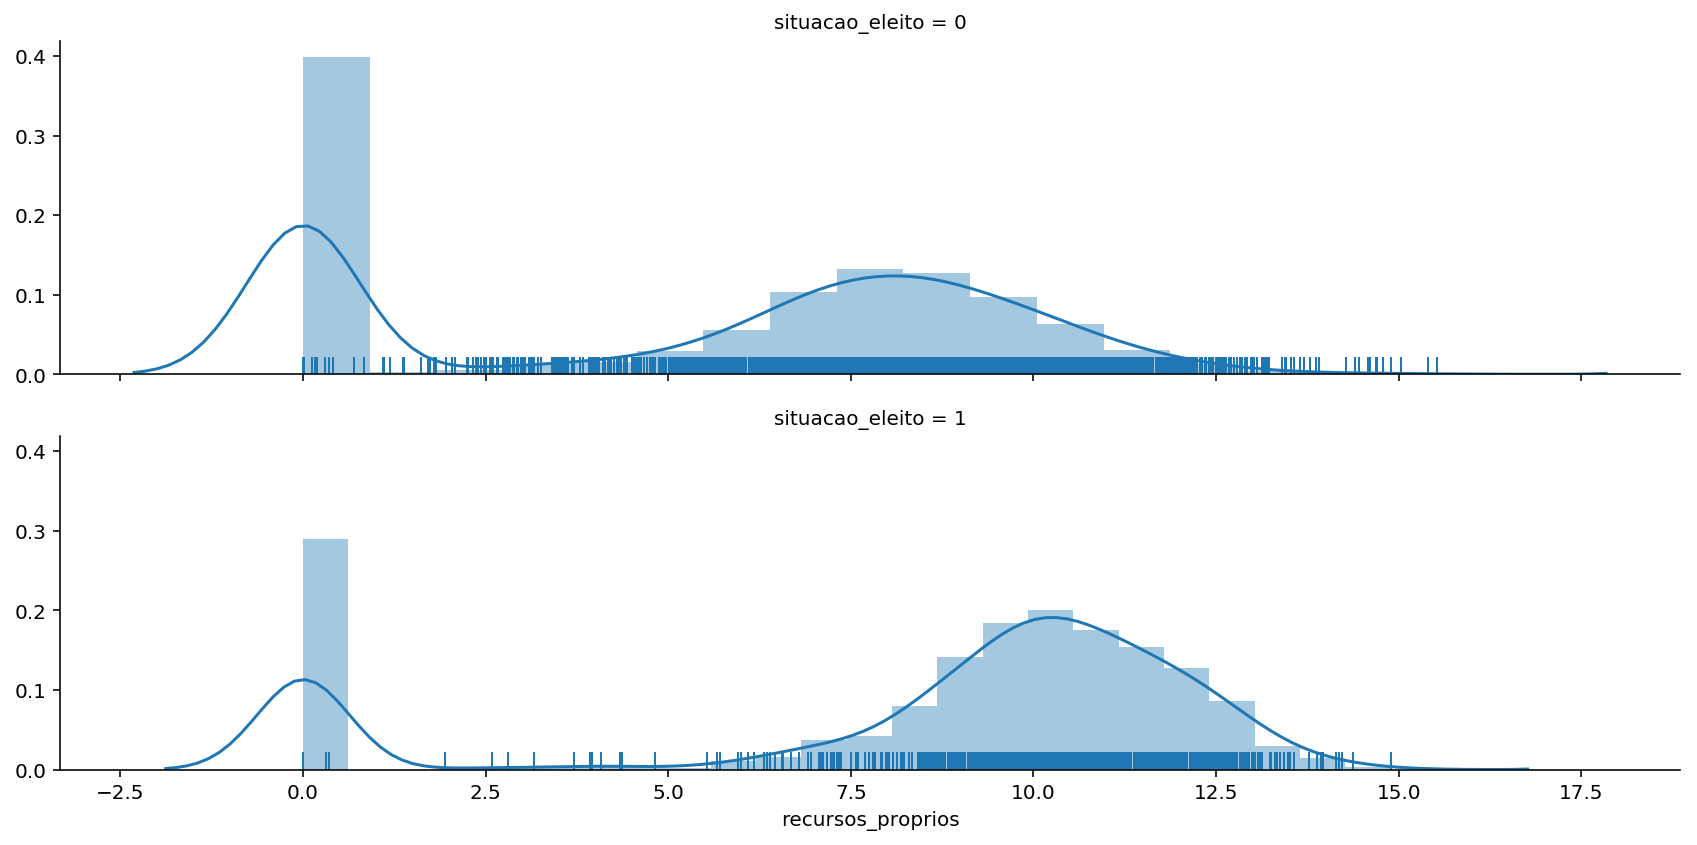

In [114]:

orderer = eleicoes_train.situacao_eleito.value_counts().index
eleicoes2=eleicoes_train

#eleicoes2["recursos_proprios"]=np.log1p(eleicoes2["recursos_proprios"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "recursos_proprios", hist=True, rug=True);

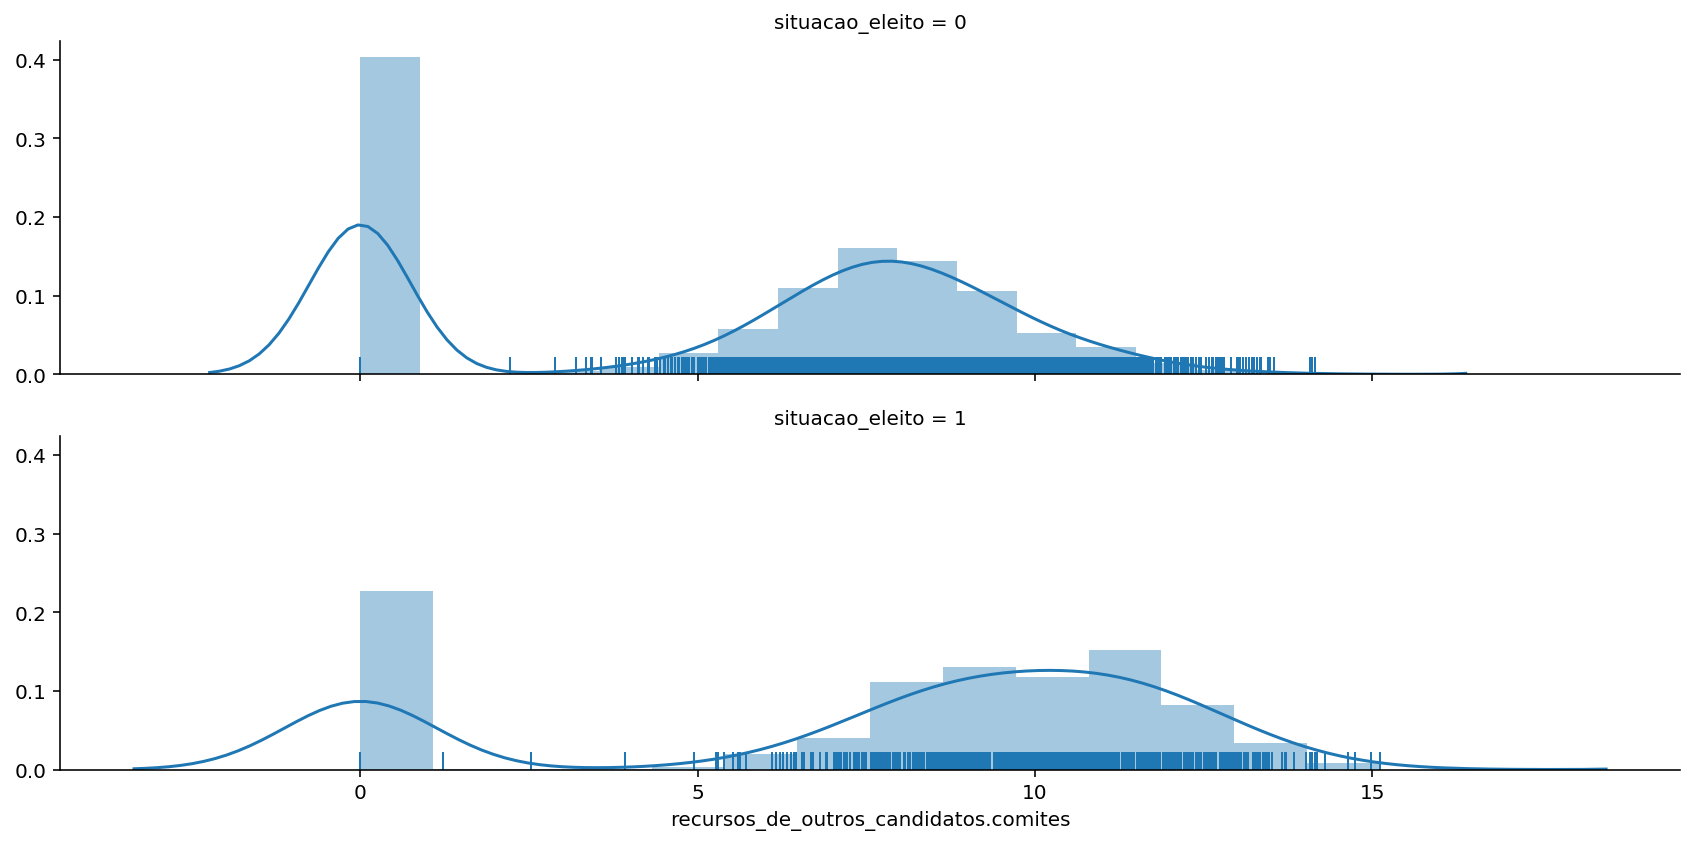

In [115]:
#eleicoes2["recursos_de_outros_candidatos.comites"]=np.log1p(eleicoes2["recursos_de_outros_candidatos.comites"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "recursos_de_outros_candidatos.comites", hist=True, rug=True);

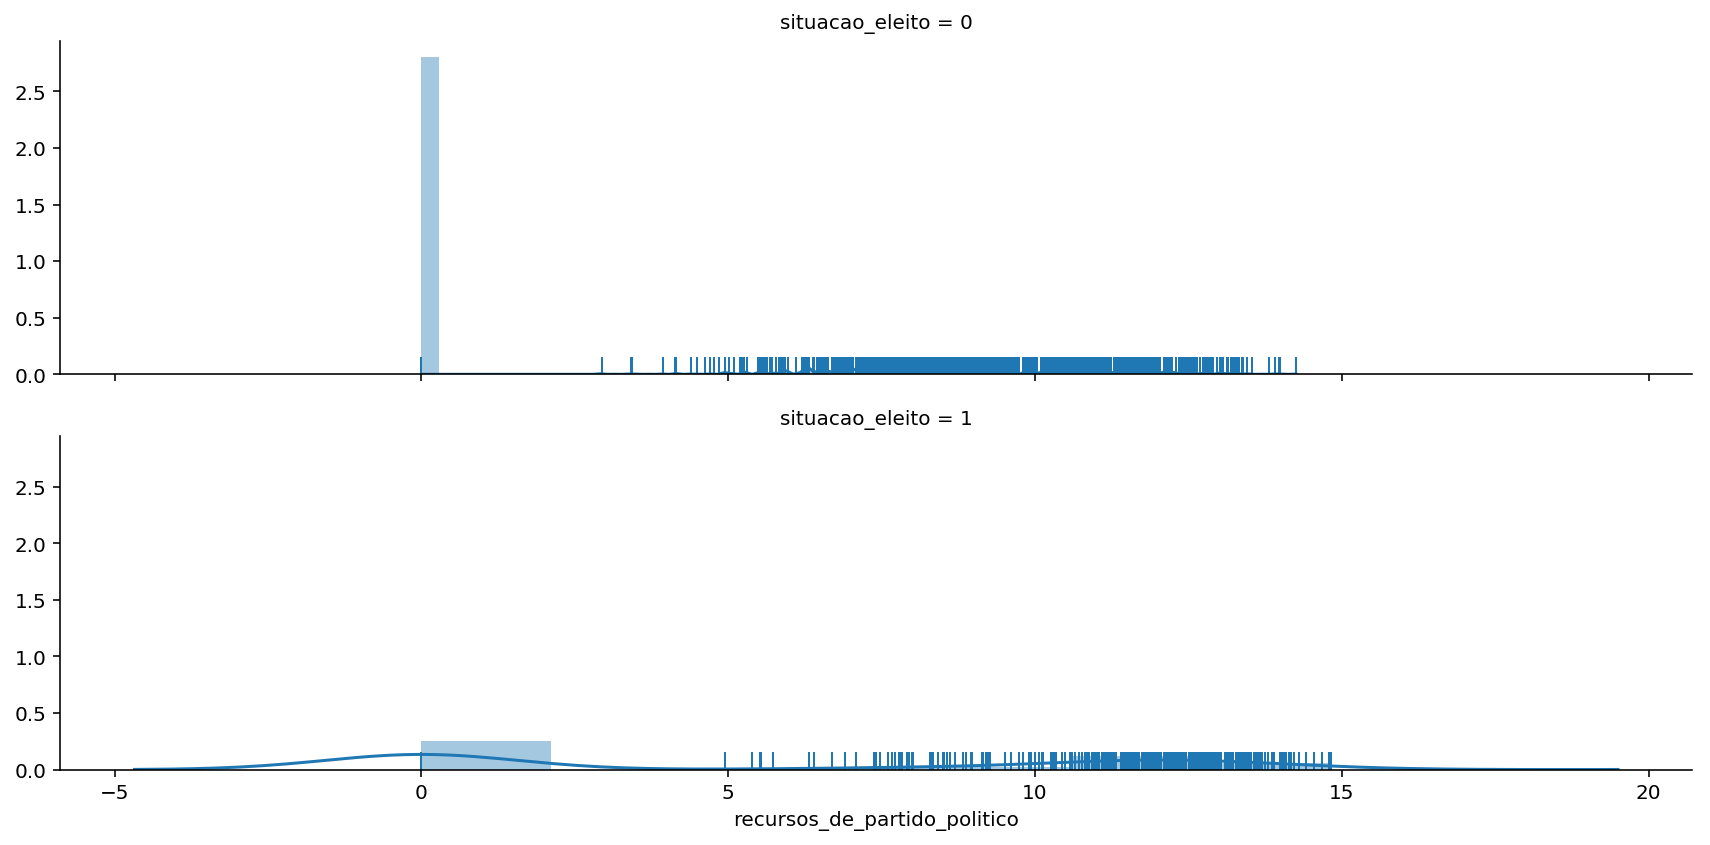

In [116]:

#eleicoes2["recursos_de_partido_politico"]=np.log1p(eleicoes2["recursos_de_partido_politico"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "recursos_de_partido_politico", hist=True, rug=True);

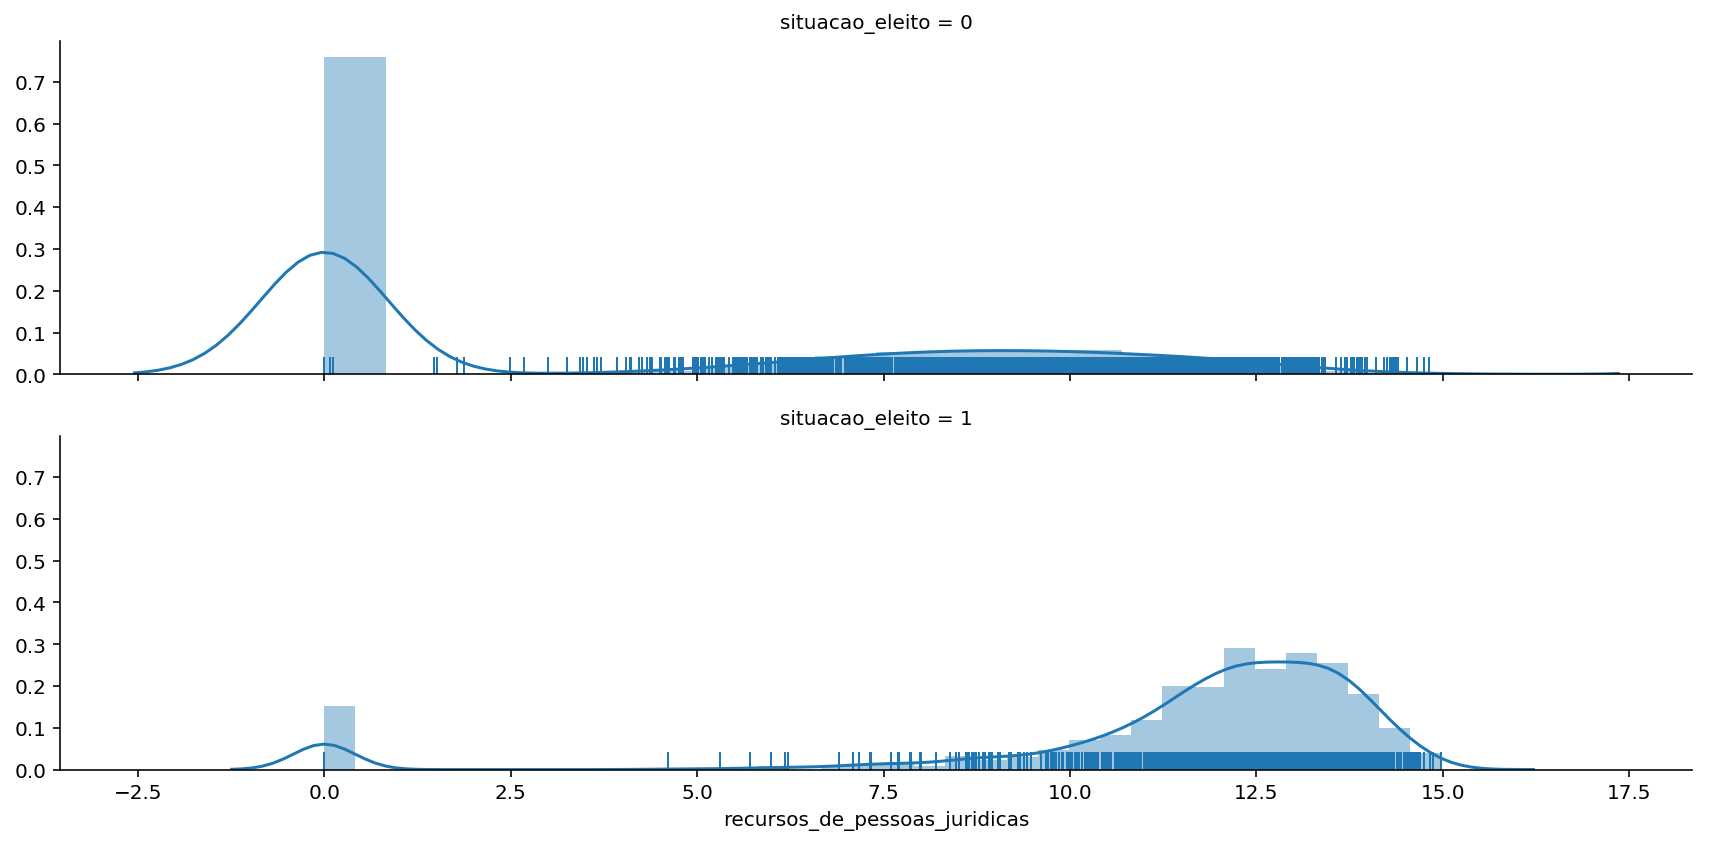

In [117]:

#eleicoes2["recursos_de_pessoas_juridicas"]=np.log1p(eleicoes2["recursos_de_pessoas_juridicas"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "recursos_de_pessoas_juridicas", hist=True, rug=True);

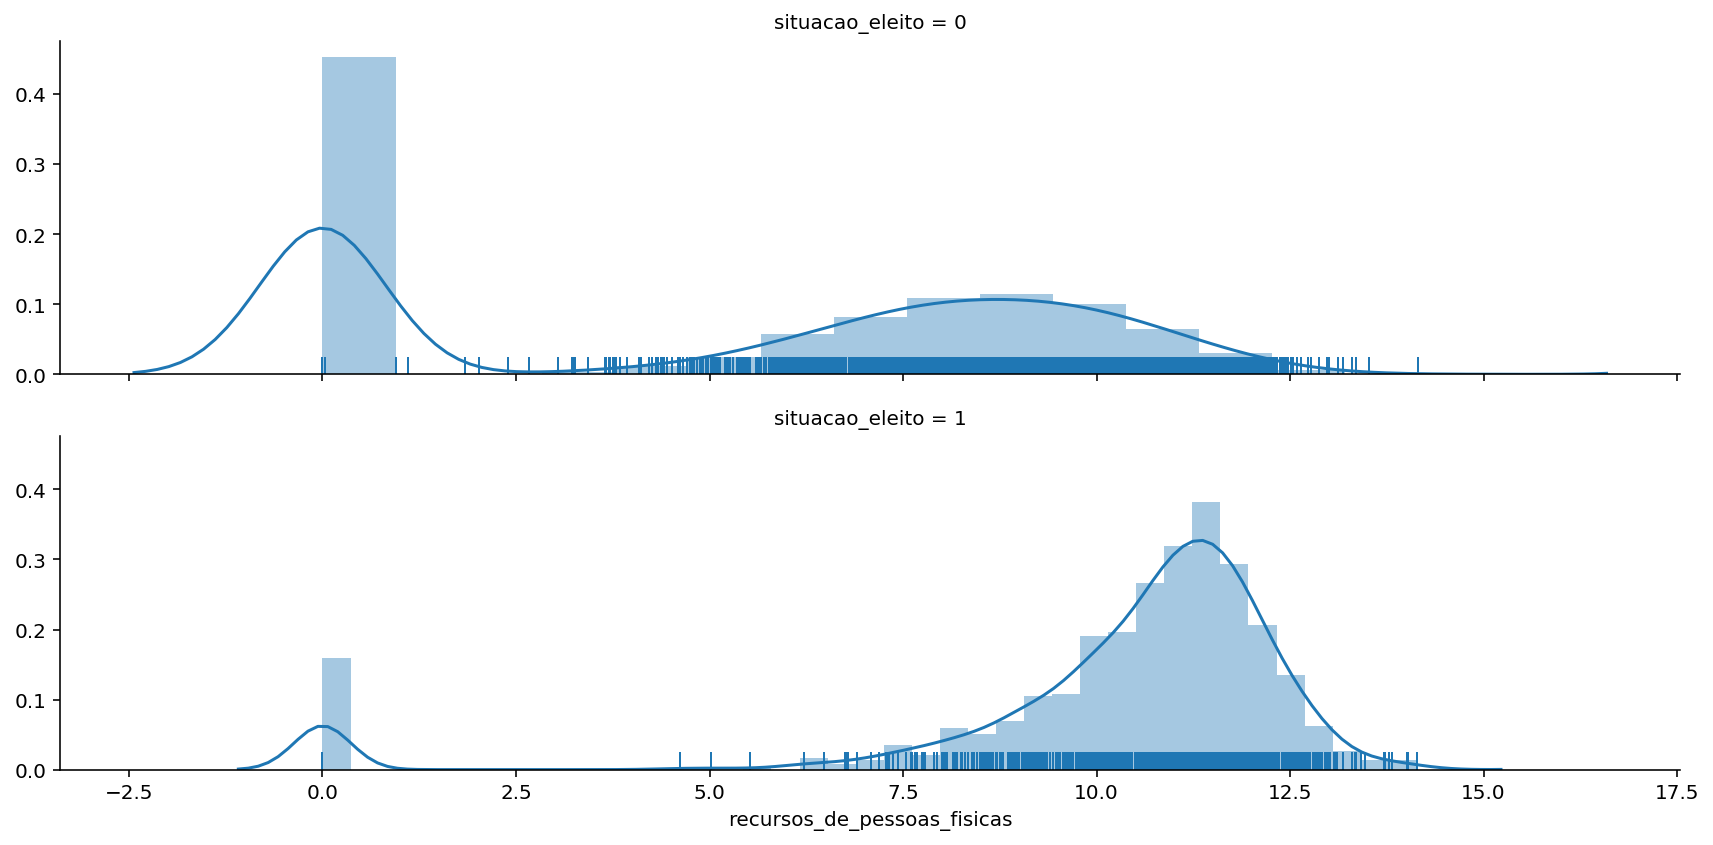

In [118]:

#eleicoes2["recursos_de_pessoas_fisicas"]=np.log1p(eleicoes2["recursos_de_pessoas_fisicas"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "recursos_de_pessoas_fisicas", hist=True, rug=True);

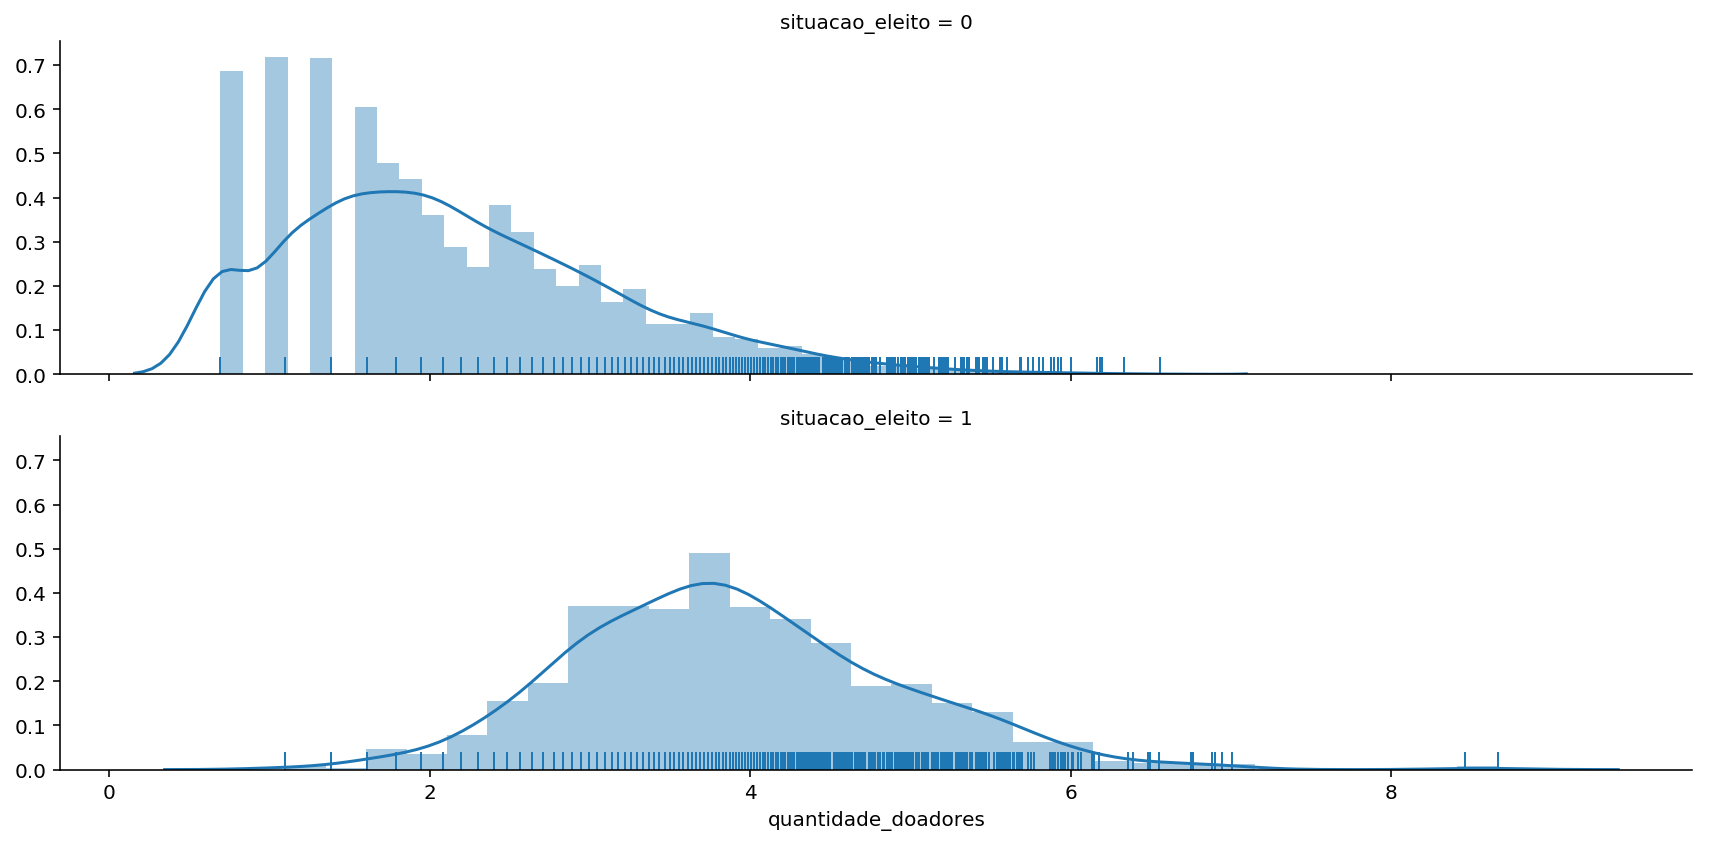

In [119]:

#eleicoes2["quantidade_doadores"]=np.log1p(eleicoes2["quantidade_doadores"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "quantidade_doadores", hist=True, rug=True);

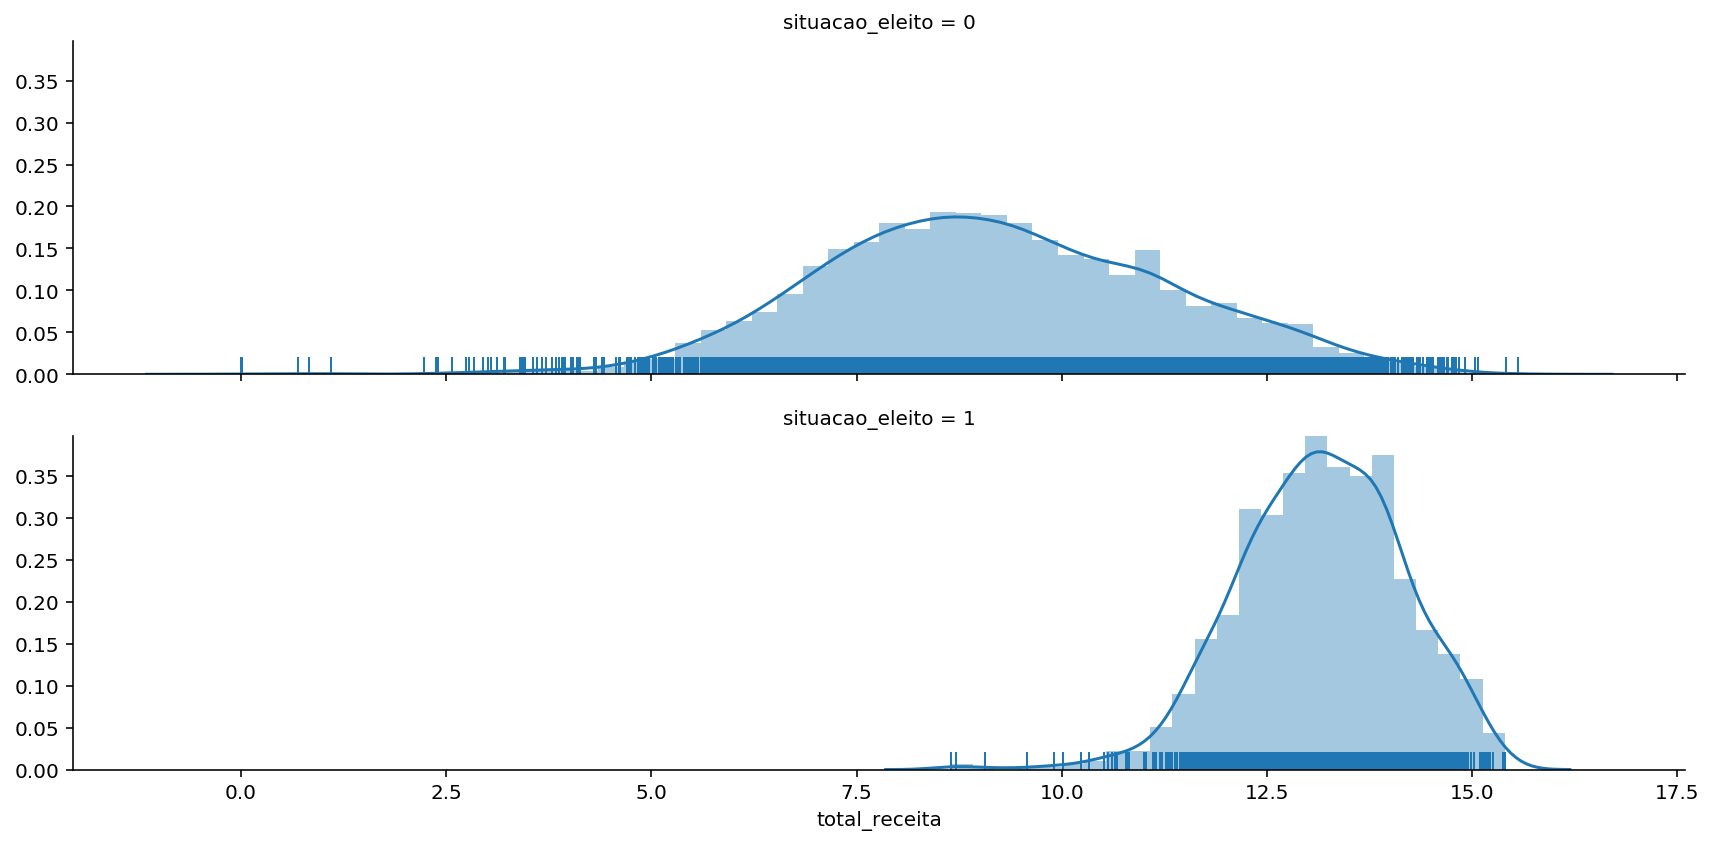

In [120]:

#eleicoes2["total_receita"]=np.log1p(eleicoes2["total_receita"])
g = sns.FacetGrid(eleicoes2, row="situacao_eleito", row_order=orderer,
                  aspect=4)
g.map(sns.distplot, "total_receita", hist=True, rug=True);

### Preenchendo lacunas

Agora iremos reindexar, preencher as células vazias, caso houver, e aplicar o balanceamento. Além disto, no bloco abaixo divido os dados de teste em três subconjuntos: os dados de treinamento (eleicoes), os dados de validação para a primeira etapa do processo de essemble por Blending (eleicoes_val) e os dados para a segunda etapa do processo (eleicoes_val2)

In [121]:
eleicoes_train_aux=eleicoes_train
eleicoes_train=eleicoes_train_balanced

#eleicoes = pd.concat((eleicoes_train,eleicoes_test),sort='false')
eleicoes = eleicoes_train
eleicoes = eleicoes.reindex(columns=eleicoes.columns)
eleicoes_final_test = eleicoes_final_test.reindex(columns=eleicoes_final_test.columns)


eleicoes, eleicoes_val = train_test_split(eleicoes, test_size=0.3, random_state=0)

eleicoes, eleicoes_val2 = train_test_split(eleicoes, test_size=0.427, random_state=0)

eleicoes = eleicoes.fillna(eleicoes.mean())
eleicoes_val = eleicoes_val.fillna(eleicoes_val.mean())
eleicoes_val2 = eleicoes_val2.fillna(eleicoes_val2.mean())

In [122]:
#função de validação cruzada
def rmse_cv(model,x,y,score='f1'):#x é dataframe e y é list
    #rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5, scoring='recall'))
    rmse= cross_val_score(model, x, y, cv = 5, scoring=score)
    return(rmse.mean())


In [123]:
eleicoes = eleicoes.reset_index()
eleicoes_val = eleicoes_val.reset_index()
eleicoes_val2 = eleicoes_val2.reset_index()
eleicoes_train = eleicoes_train.reset_index()
eleicoes_final_test = eleicoes_final_test.reset_index()

## Análise de algorítmos

Iremos agora experimentar diversos algoritmos e diversas estratégias de predição, avaliando-as com base nas métricas F1, Recall, Precision e AUC. Sempre parametrizando com base em validação cruzada

A profundidade ideal é 7, com F1 = 0.7018856110731256
Precision: 0.7083673809174142
Recall: 0.692024627042387
AUC: 0.9163298392558609
0.923956931359354
0.9172289698605488
0.9178329571106095


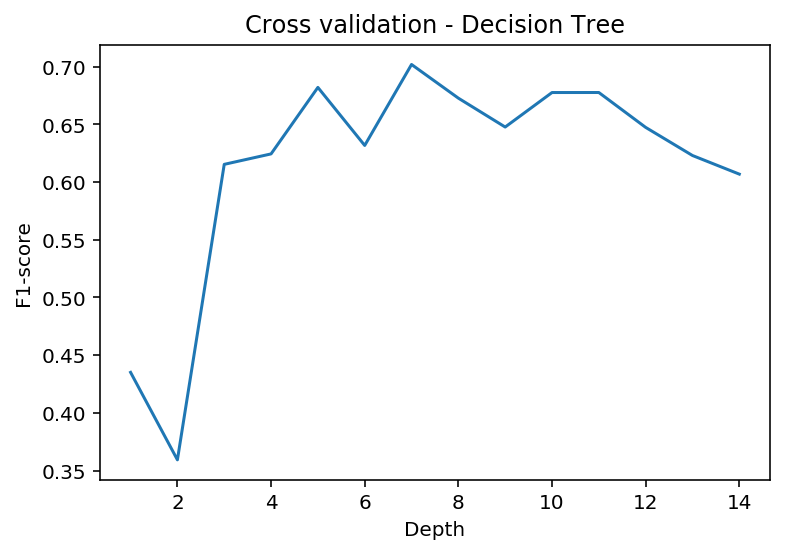

In [124]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree

depths = np.arange(1,15,1).tolist()
cv_tree =  [rmse_cv(
    tree.DecisionTreeClassifier(
        criterion = "entropy", 
        splitter = "random", 
        max_leaf_nodes = 12, 
        min_samples_leaf = 15, 
        max_depth= depth),
    eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_train.loc[:,['situacao_eleito']],
    'f1').mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")

print("A profundidade ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

model1 = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'random', max_leaf_nodes = 12, min_samples_leaf = 15, max_depth= 8)

print("Precision: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      
      

#model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas']], eleicoes.loc[:,['situacao_eleito']])
model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
#val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas']])
val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
#test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas']])
test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

print(model1.score(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))

O melhor alpha é 0.024, com F1 = 0.662780583842834
Precision: 0.764994371349434
Recall: 0.6472365616860052
AUC: 0.9264361105126457
0.9330417227456258
0.9244264507422402
0.9218961625282167


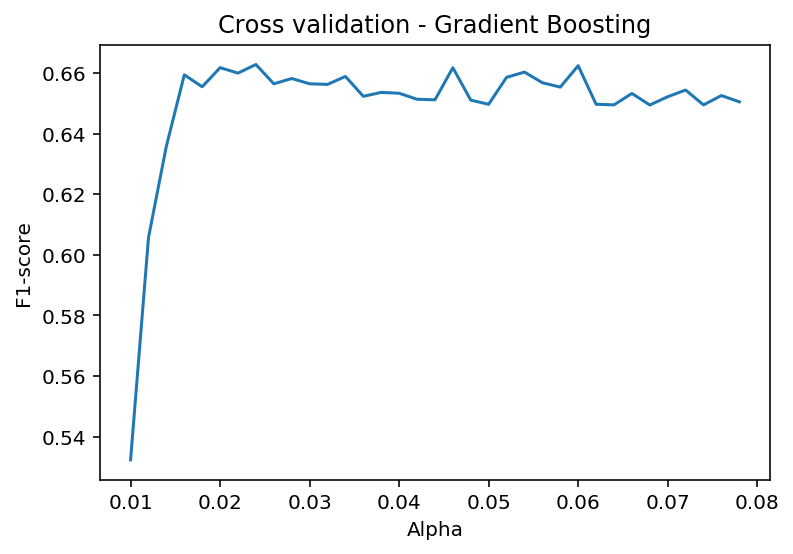

In [125]:
from sklearn.ensemble import AdaBoostClassifier





estimators = np.arange(1,50,10).tolist()
cv_ada =  [rmse_cv(
    AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
    eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
cv_ada.plot(title = "Cross validation - Adaboosting")
plt.xlabel("Estimator")
plt.ylabel("F1-score")

print("O melhor estimador é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

model1 = AdaBoostClassifier(GradientBoostingClassifier(learning_rate=0.062,random_state=1), 
                                    algorithm="SAMME", 
                                    n_estimators=1)

print("Precision: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      
      



#model1 = AdaBoostClassifier(random_state=1)
#model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas']], eleicoes.loc[:,['situacao_eleito']])
model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
#val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas']])
val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
#test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas']])
test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)
print(model1.score(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))



O melhor estimador é 1, com F1 = 0.6853655160058943
Precision: 0.7531437663473388
Recall: 0.6589391427894863
AUC: 0.8114543736472797
0.9374158815612382
0.9230769230769231
0.9200902934537246


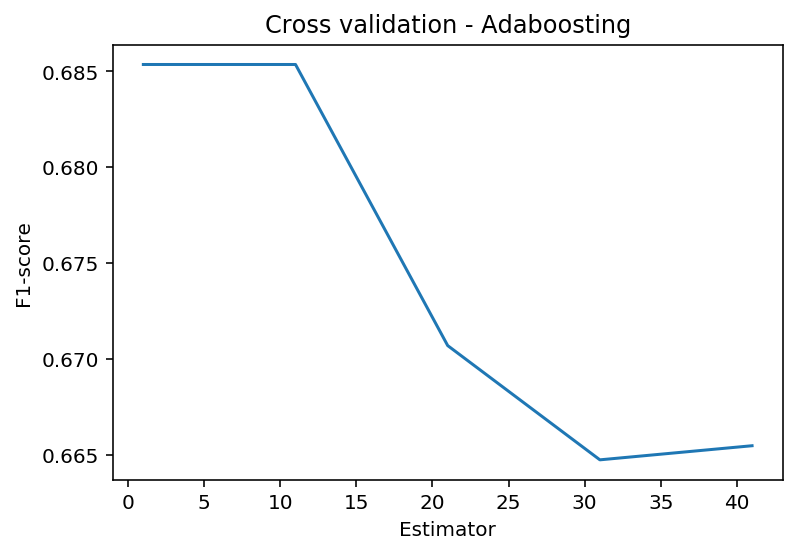

In [126]:

from sklearn.ensemble import GradientBoostingClassifier



alphas = np.arange(0.01,0.08,0.002).tolist()
cv_gb =  [rmse_cv(
    GradientBoostingClassifier(learning_rate=alpha,random_state=1),
    eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for alpha in alphas]
cv_gb = pd.Series(cv_gb, index = alphas)
cv_gb.plot(title = "Cross validation - Gradient Boosting")
plt.xlabel("Alpha")
plt.ylabel("F1-score")

print("O melhor alpha é {0}, com F1 = {1}".format(cv_gb.idxmax(), cv_gb.max()))

model1 = GradientBoostingClassifier(learning_rate=0.024,random_state=1)

print("Precision: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model1,eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      
      


#model1 = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
#model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas']], eleicoes.loc[:,['situacao_eleito']])
model1.fit(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
#val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas']])
val_pred1=model1.predict(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
#test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas']])
test_pred1=model1.predict(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

#print(rmse_cv(model1,eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']],'precision'))
#print(rmse_cv(model1,eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']],'recall'))
#print(rmse_cv(model1,eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']],'f1'))

print(model1.score(eleicoes.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model1.score(eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))

A melhor quantidade de vizinhos é 17, com F1 = 0.4778238477660775
Precision: 0.6664509561535323
Recall: 0.5136159128581578
AUC: 0.8188475896510872
0.9192462987886945
0.896536212325686
0.8821670428893905


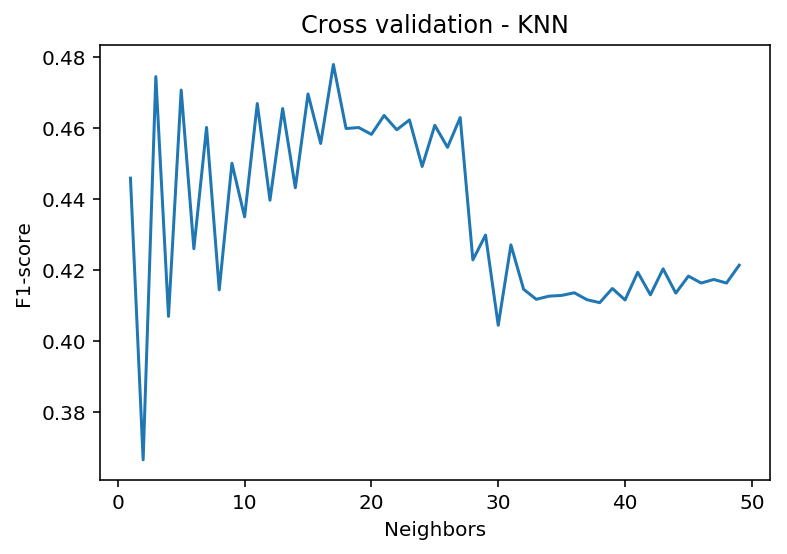

In [127]:
from sklearn.neighbors import KNeighborsClassifier






neighbors = np.arange(1,50,1).tolist()
cv_knn =  [rmse_cv(
    KNeighborsClassifier(n_neighbors=neighbor),
    eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbors")
plt.ylabel("F1-score")

print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

model2 = KNeighborsClassifier(n_neighbors=7)

print("Precision: {0}".format(rmse_cv(model2,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model2,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model2,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      


#model2 = KNeighborsClassifier()
model2.fit(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_proprios']], eleicoes.loc[:,['situacao_eleito']])
val_pred2=model2.predict(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_proprios']])
test_pred2=model2.predict(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_proprios']])
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

print(model2.score(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes.loc[:,['situacao_eleito']]))
print(model2.score(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model2.score(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_val2.loc[:,['situacao_eleito']]))
#model2.score(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_proprios']],eleicoes_val2.loc[:,['situacao_eleito']])

O melhor estimador é 1, com F1 = 0.58924330055909
Precision: 0.7477283561252458
Recall: 0.519493251243192
AUC: 0.9232090078664805
0.9216016150740243
0.9082321187584346
0.9060948081264109


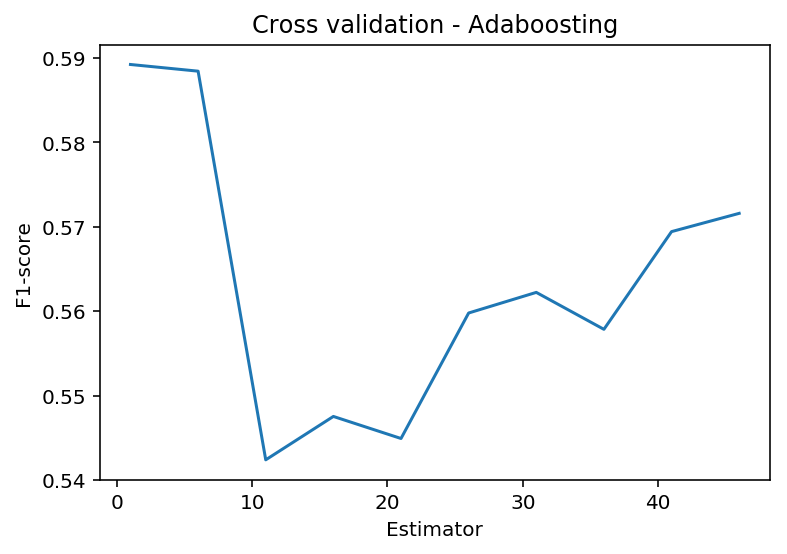

In [128]:
from sklearn.ensemble import AdaBoostClassifier

estimators = np.arange(1,50,5).tolist()
cv_ada =  [rmse_cv(
    AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
    eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
cv_ada.plot(title = "Cross validation - Adaboosting")
plt.xlabel("Estimator")
plt.ylabel("F1-score")

print("O melhor estimador é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

model3 = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=31)

print("Precision: {0}".format(rmse_cv(model3,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model3,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model3,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      


#model3 = AdaBoostClassifier(random_state=1)
model3.fit(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
val_pred3=model3.predict(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
test_pred3=model3.predict(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred3=pd.DataFrame(val_pred3)
test_pred3=pd.DataFrame(test_pred3)

print(model3.score(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model3.score(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model3.score(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))

O melhor estimador é 31, com F1 = 0.5595605570078378
Precision: 0.7607670395003147
Recall: 0.49998579209093064
AUC: 0.9349043386421864
0.9175639300134589
0.9037336932073774
0.9011286681715576


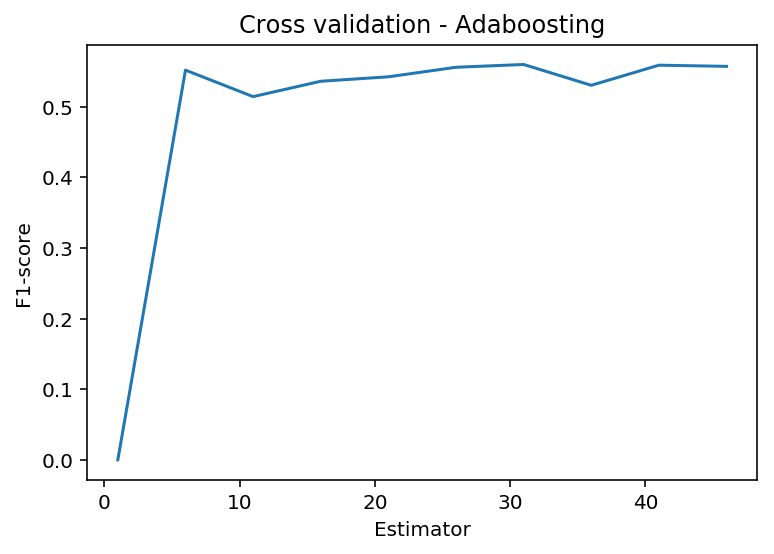

In [129]:
from sklearn.ensemble import AdaBoostClassifier

estimators = np.arange(1,50,5).tolist()
cv_ada =  [rmse_cv(
    AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
    eleicoes_val2.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
cv_ada.plot(title = "Cross validation - Adaboosting")
plt.xlabel("Estimator")
plt.ylabel("F1-score")

print("O melhor estimador é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

model4 = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=31)

print("Precision: {0}".format(rmse_cv(model4,eleicoes_train.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model4,eleicoes_train.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model4,eleicoes_train.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      


#model4 = AdaBoostClassifier(random_state=1)
model4.fit(eleicoes.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
val_pred4=model4.predict(eleicoes_val.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
test_pred4=model4.predict(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred4=pd.DataFrame(val_pred4)
test_pred4=pd.DataFrame(test_pred4)

print(model4.score(eleicoes.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model4.score(eleicoes_val.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model4.score(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','quantidade_doadores','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))

O melhor total de estimadores é 41, com F1 = 0.5204789140547549
Precision: 0.7416432237230556
Recall: 0.4327681742836845
AUC: 0.8234017115408687
0.9148721399730821
0.905982905982906
0.8943566591422122


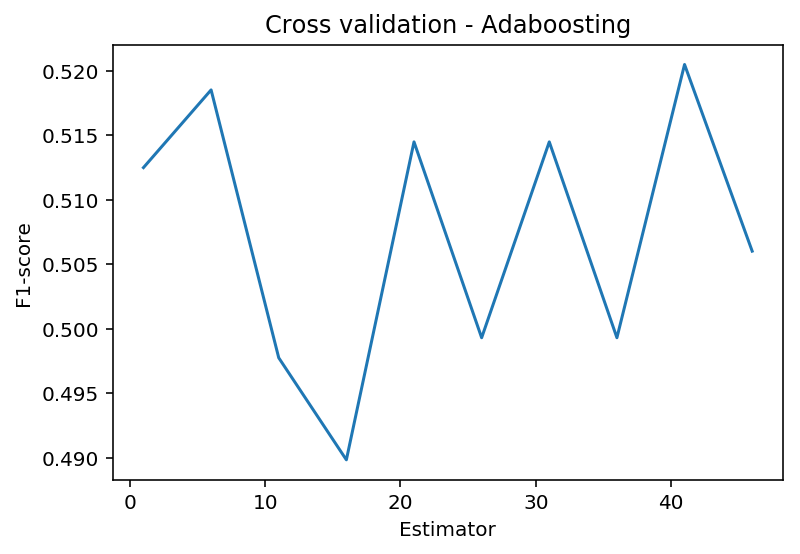

In [130]:
from sklearn.ensemble import AdaBoostClassifier

estimators = np.arange(1,50,5).tolist()
cv_ada =  [rmse_cv(
    AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
    eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
cv_ada.plot(title = "Cross validation - Adaboosting")
plt.xlabel("Estimator")
plt.ylabel("F1-score")

print("O melhor total de estimadores é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

model5 = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=41)

print("Precision: {0}".format(rmse_cv(model5,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model5,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model5,eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_train.loc[:,['situacao_eleito']],'roc_auc')))
      

#model5 = AdaBoostClassifier(random_state=1)
model5.fit(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes.loc[:,['situacao_eleito']])
val_pred5=model5.predict(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
test_pred5=model5.predict(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred5=pd.DataFrame(val_pred5)
test_pred5=pd.DataFrame(test_pred5)

print(model5.score(eleicoes.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes.loc[:,['situacao_eleito']]))
print(model5.score(eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val.loc[:,['situacao_eleito']]))
print(model5.score(eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']],eleicoes_val2.loc[:,['situacao_eleito']]))

O melhor lambda é 1.4, com F1 = 0.6618929909296882
Precision: 0.73189592760181
Recall: 0.60448087431694
AUC: 0.9472174045504895
0.9271255060728745
0.9146726862302483


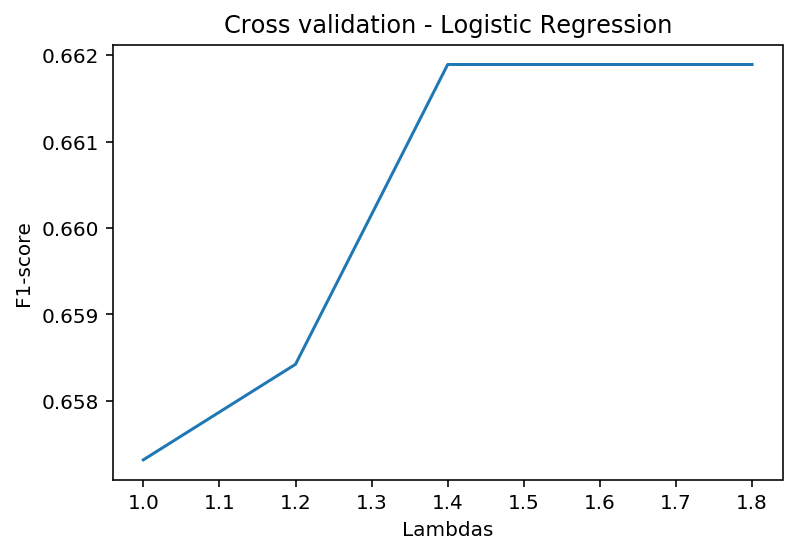

In [131]:
from sklearn.linear_model import LogisticRegression



#df_val=pd.concat([eleicoes_val.loc[:,['recursos_de_pessoas_juridicas','recursos_proprios']], val_pred1,val_pred2],axis=1)
df_val=pd.concat([eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','quantidade_doadores','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], val_pred1,val_pred2,val_pred3,val_pred4,val_pred5],axis=1)
#df_test=pd.concat([eleicoes_val2.loc[:,['recursos_de_pessoas_juridicas','recursos_proprios']], test_pred1,test_pred2],axis=1)
df_test=pd.concat([eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_partido_politico','quantidade_doadores','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], test_pred1,test_pred2,test_pred3,test_pred4,test_pred5],axis=1)




lambdas = np.arange(1.0,2,0.2).tolist()
#lambdas = np.arange(0.1,2,0.5).tolist()
#lambdas = np.arange(0.01,0.6,0.1).tolist()
cv_logRegression =  [rmse_cv(
    LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), 
    df_test,
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambdas")
plt.ylabel("F1-score")

print("O melhor lambda é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

model = LogisticRegression(solver="lbfgs", max_iter=10000, C=1.59, random_state=1)

print("Precision: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'roc_auc')))
      

#model = LogisticRegression()
model.fit(df_val,eleicoes_val.loc[:,['situacao_eleito']])



print(model.score(df_val,eleicoes_val.loc[:,['situacao_eleito']]))
print(model.score(df_test,eleicoes_val2.loc[:,['situacao_eleito']]))

In [136]:
from sklearn.ensemble import RandomForestClassifier

df_val=pd.concat([eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], val_pred1,val_pred2,val_pred3],axis=1)
df_test=pd.concat([eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], test_pred1,test_pred2,test_pred3],axis=1)






trees = np.arange(1,15,1).tolist()
cv_random_forest =  [rmse_cv(
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion="gini",
                               max_depth=15, max_features="auto", max_leaf_nodes=10,
                               min_samples_leaf=3,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               n_estimators=tree, n_jobs=1, oob_score=False, random_state=1,
                               verbose=0, warm_start=False), 
    df_test,
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for tree in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Trees")
plt.ylabel("F1-score")

print("O melhor número de árvores é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion="gini",
                               max_depth=15, max_features="auto", max_leaf_nodes=10,
                               min_samples_leaf=3,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               n_estimators=14, n_jobs=1, oob_score=False, random_state=1,
                               verbose=0, warm_start=False)

print("Precision: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'roc_auc')))
      
      

model.fit(df_val,eleicoes_val.loc[:,['situacao_eleito']])
print(model.score(df_val,eleicoes_val.loc[:,['situacao_eleito']]))
print(model.score(df_test,eleicoes_val2.loc[:,['situacao_eleito']]))

ValueError: Found input variables with inconsistent numbers of samples: [4592, 2215]

Abaixo integramos três do modelos selecionados acima, um Gradient Boosting (model1), um Adaboosting (model2) e um KNN (model3) utilizando outro Gradient boosting utilizando um conjunto de validação separado (eleicoes_val2). Esta estratégia é conhecida como Blending.

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

df_val=pd.concat([eleicoes_val.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], val_pred1,val_pred2,val_pred3],axis=1)
df_test=pd.concat([eleicoes_val2.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], test_pred1,test_pred2,test_pred3],axis=1)


alphas = np.arange(0.01,0.08,0.002).tolist()
cv_gb =  [rmse_cv(
    GradientBoostingClassifier(learning_rate=alpha,random_state=1),
    df_test,
    eleicoes_val2.loc[:,['situacao_eleito']],
    'f1').mean() 
            for alpha in alphas]
cv_gb = pd.Series(cv_gb, index = alphas)
cv_gb.plot(title = "Cross validation - Gradient Boosting")
plt.xlabel("Alpha")
plt.ylabel("F1-score")

print("O melhor alpha é {0}, com F1 = {1}".format(cv_gb.idxmax(), cv_gb.max()))

model = GradientBoostingClassifier(learning_rate=0.026,random_state=1)



#model = GradientBoostingClassifier(learning_rate=0.024,random_state=1)

print("Precision: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'precision')))
print("Recall: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'recall')))
print("AUC: {0}".format(rmse_cv(model,df_test,eleicoes_val2.loc[:,['situacao_eleito']],'roc_auc')))
      
    
model.fit(df_val,eleicoes_val.loc[:,['situacao_eleito']])
print(model.score(df_val,eleicoes_val.loc[:,['situacao_eleito']]))
print(model.score(df_test,eleicoes_val2.loc[:,['situacao_eleito']]))

ValueError: Found input variables with inconsistent numbers of samples: [4592, 2215]

## Submissão

O passo final deste laboratório é submeter o melhor resultado em uma competição Kaggle. No nosso caso, utilizamos balaceamento por Tomek Links, essemble utilizando Blending (Gradient Boosting, Adaboosting e KNN) e validação cruzada.

In [137]:
import csv

model1.fit(eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes_train.loc[:,['situacao_eleito']])
val_pred1=model1.predict(eleicoes_train.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred1=pd.DataFrame(val_pred1)
test_pred1=model1.predict(eleicoes_final_test.loc[:,['recursos_de_pessoas_juridicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
test_pred1=pd.DataFrame(test_pred1)


model2.fit(eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_proprios']], eleicoes_train.loc[:,['situacao_eleito']])
val_pred2=model2.predict(eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_proprios']])
val_pred2=pd.DataFrame(val_pred2)
test_pred2=model2.predict(eleicoes_final_test.loc[:,['ocupacao_DEPUTADO','recursos_proprios']])
test_pred2=pd.DataFrame(test_pred2)


model3.fit(eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']], eleicoes_train.loc[:,['situacao_eleito']])
val_pred3=model3.predict(eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
val_pred3=pd.DataFrame(val_pred3)
test_pred3=model3.predict(eleicoes_final_test.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_fisicas','regiao_SE','regiao_NE','regiao_NO','regiao_SU','ideologia_R','ideologia_C']])
test_pred3=pd.DataFrame(test_pred3)


df_final_train=pd.concat([eleicoes_train.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], val_pred1,val_pred2,val_pred3],axis=1)

df_final_test=pd.concat([eleicoes_final_test.loc[:,['ocupacao_DEPUTADO','recursos_de_pessoas_juridicas','recursos_de_pessoas_fisicas','ideologia_R','ideologia_C']], test_pred1,test_pred2,test_pred3],axis=1)

model.fit(df_final_train, eleicoes_train.loc[:,['situacao_eleito']])

predict = model.predict(df_final_test)
#predict = pd.DataFrame({"Id":eleicoes_final_test.loc[:,['sequencial_candidato']],"Predicted":predict[1]}  {predict[1]})
final_predict = pd.DataFrame(columns=["Id","Predicted"],index=eleicoes_final_test.index)
final_predict["Id"]=eleicoes_final_test.loc[:,['sequencial_candidato']]
final_predict["Predicted"]=["eleito" if x==1 else "nao_eleito" for x in predict]    
final_predict.to_csv("submission_sample.csv", quotechar='"', quoting=csv.QUOTE_ALL, encoding='utf-8', index=False)

## Conclusões

Podemos notar que nem sempre um bom resultado na validação determina um bom modelo. O balanciamento de carga, a análise de Recall, Precision e AUC são determinantes para um bom resultado.
